In [1]:
using Plots
@time include("../src/federn/federn.jl");

INFO: Recompiling stale cache file /home/numerik/bzfsikor/.julia/lib/v0.5/KernelDensity.ji for module KernelDensity.
INFO: Recompiling stale cache file /home/numerik/bzfsikor/.julia/lib/v0.5/Mamba.ji for module Mamba.


 79.829809 seconds (29.92 M allocations: 935.541 MB, 1.58% gc time)


In [2]:
#switch between peturbed and unperturbed Lzz versions

#Lzz = [rho_error(z-z2) for z in zs, z2 in zs] # unperturbed
#Lzz = [rho_error(z-z2) for z in zps, z2 in zs]  # perturbed


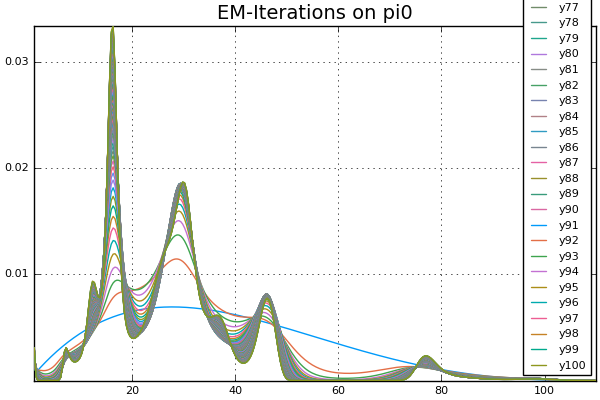

In [3]:
# define beta distribution prior, and get corresponding sampling weights
s = xmax+1
pi_0(x) = (x/s).*(1-x/s).^3.*(x/s.>0).*(x/s.<1)*20/s
betaw=map(pi_0, samples)
betaw=betaw/sum(betaw)

w0 = betaw

title = "EM-Iterations on pi0"
plot(samples, ws_em(betaw, 100), title=title)

In [4]:
# compare different zentropies
randw = rand(300)
randw = randw/sum(randw)
unitw = ones(300) / 300

@show zentropy(randw)
@show zentropy(unitw)
@show zentropy(betaw)

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


zentropy(randw) = 5.910737827040075
zentropy(unitw) = 5.929634303189476
zentropy(betaw) = 5.961635141671259


5.961635141671259

In [5]:
# dictionary for different weightings
wdict = Dict{String, Vector{Vector{Float64}}}()
niter = 50;

In [6]:
# gradientascent penalized max. likelihood
# with stepsize `h` and entropy weighting `s`
gapml(w0, niter, h=1, s=1) = gradientascent(x->pml(x,s), w0, niter, h, GynC.projectsimplex)

gapml (generic function with 3 methods)

In [7]:
wdict["em"]  = ws_em(w0, niter)
wdict["pml e-7"] =     gapml(w0, niter, 0.0000001)
wdict["pml e-6"] =     gapml(w0, niter, 0.000001)
wdict["pml e-6 se1"] = gapml(w0, niter, 0.000001, 10)
wdict["pml e-6 se3"] = gapml(w0, niter, 0.000001, 1000)
wdict["l   e-6  s0"] = gapml(w0, niter, 0.000001, 0)
wdict["ze e-3"] = gradientascent(x->zentropy(x), w0, niter, 0.001, GynC.projectsimplex);


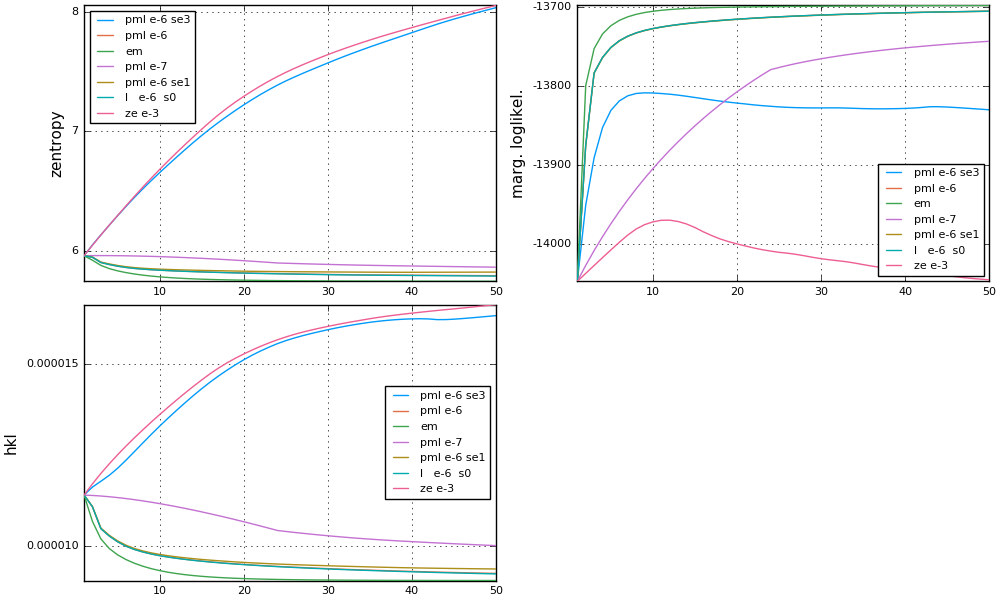

In [8]:
include("../src/optim3.jl")

zeplot = plot(yaxis="zentropy")
mlplot = plot(yaxis="marg. loglikel.")
hklplot = plot(yaxis="hkl")

for (key, ws) in wdict
    plot!(zeplot, map(zentropy, ws), label=key)
    plot!(mlplot, map(marginallikelihood, ws), label=key)
    plot!(hklplot, map(w->HKL(w,Lzz), ws), label=key)
end
plot(zeplot, mlplot, hklplot, size=(1000,600))


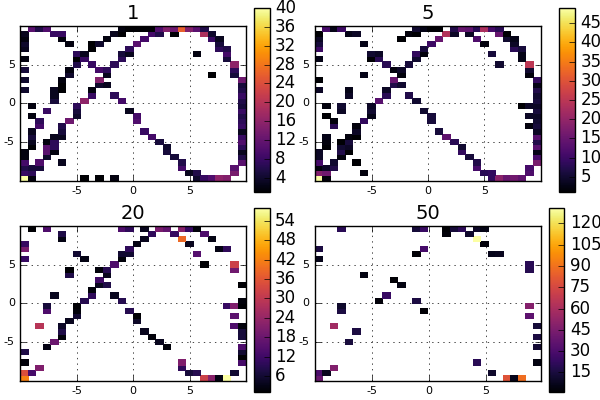

In [9]:
ww=wdict["ze e-3"]

function zplot(w; args...)
    zsmpls = sample(GynC.WeightedSampling(zs, w), 1000)
    histogram2d(map(x->x[1], zsmpls), map(x->x[2], zsmpls); args...)
end
plot([zplot(ww[i], title=i) for i=[1,5,20,50]]...)


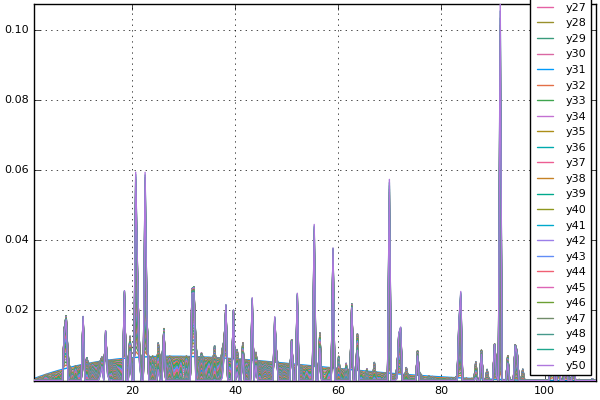

In [10]:
function plotiters(ws; kwargs...)
    plot(samples,hcat(ws...), kwargs...)
end

plotiters(ww)


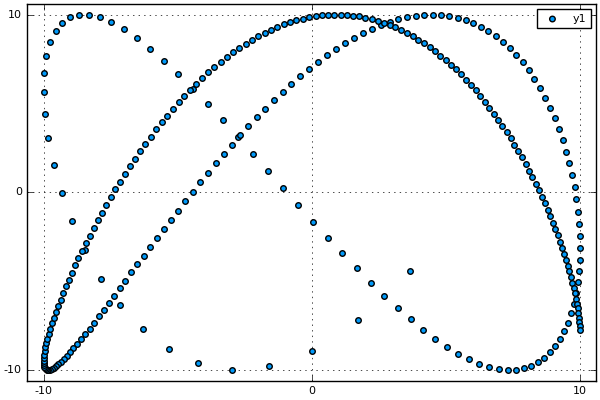

In [11]:
temp = hcat(zs...)
scatter(temp[1,:],temp[2,:])


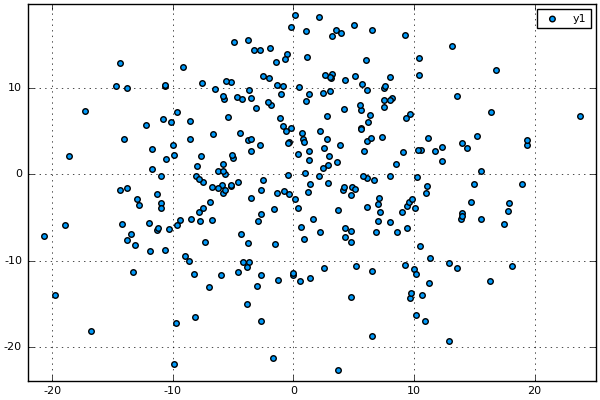

In [12]:
temp = hcat(zps...)
scatter(temp[1,:],temp[2,:])

In [13]:
# generate multiple, perturbed z-meas. per x 

nerrspl = 20 # n error samples

ntimes(w,n) = repeat(w, inner=[n])
ntimespert(zs, n) = map(x -> x+randn(2) * rho_std, ntimes(zs, n));

# adapt the Lzz matrix
Lzzbig = [rho_error(z-zp) for zp in ntimespert(zs, nerrspl), z in zs];

In [14]:
include("../src/optim3.jl")
gahkl(w0, niter, h=1, s=1) = gradientascent(w->HKL(w, Lzzbig, ntimes(w, nerrspl)), w0, niter, h, GynC.projectsimplex)

@time hkl = gahkl(w0, 10, 1e2);

push!(wdict, "hkl" => hkl)

244.327352 seconds (1.63 G allocations: 145.536 GB, 32.10% gc time)


Dict{String,Array{Array{Float64,1},1}} with 8 entries:
  "pml e-6 se3" => Array{Float64,1}[[0.000576205,0.000778468,0.000976634,0.0011…
  "pml e-6"     => Array{Float64,1}[[0.000576205,0.000778468,0.000976634,0.0011…
  "em"          => Array{Float64,1}[[0.000576205,0.000778468,0.000976634,0.0011…
  "pml e-7"     => Array{Float64,1}[[0.000576205,0.000778468,0.000976634,0.0011…
  "pml e-6 se1" => Array{Float64,1}[[0.000576205,0.000778468,0.000976634,0.0011…
  "hkl"         => Array{Float64,1}[[0.000576205,0.000778468,0.000976634,0.0011…
  "l   e-6  s0" => Array{Float64,1}[[0.000576205,0.000778468,0.000976634,0.0011…
  "ze e-3"      => Array{Float64,1}[[0.000576205,0.000778468,0.000976634,0.0011…


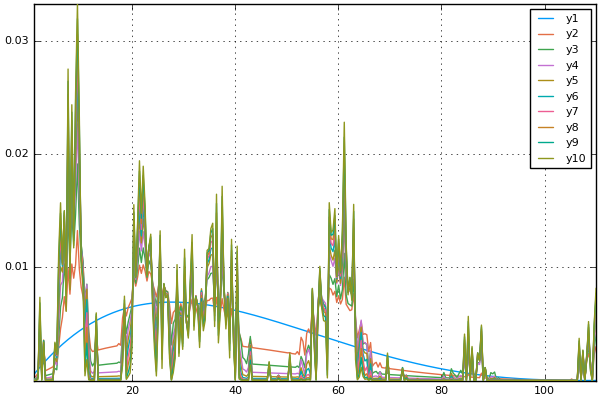

In [15]:
plotiters(hkl)

In [16]:
(hkl[end] .== 0) |> any

false

In [17]:
using KernelDensity
function plot_priorpredictivedistr(w; kwargs...)
  zsx = map(x->x[1], zs)
  zsy = map(x->x[2], zs)

  k=kde((zsx,zsy), weights = w)
  contour(k.x, k.y, k.density, title="Prior predictive distribution"; kwargs...)
end

plot_priorpredictivedistr (generic function with 1 method)

Interact.Options{:ToggleButtons,Any}(Signal{Any}(Array{Float64,1}[[0.000576205,0.000778468,0.000976634,0.00117074,0.00136084,0.00154696,0.00172914,0.00190743,0.00208187,0.00225249,0.00241935,0.00258246,0.00274188,0.00289765,0.0030498,0.00319837,0.00334341,0.00348494,0.00362302,0.00375767,0.00388893,0.00401685,0.00414145,0.00426279,0.00438089,0.00449579,0.00460753,0.00471615,0.00482167,0.00492415,0.00502361,0.00512009,0.00521363,0.00530426,0.00539202,0.00547694,0.00555905,0.0056384,0.00571502,0.00578894,0.0058602,0.00592882,0.00599485,0.00605832,0.00611926,0.00617771,0.00623369,0.00628725,0.00633841,0.00638721,0.00643367,0.00647784,0.00651974,0.00655941,0.00659687,0.00663217,0.00666532,0.00669637,0.00672534,0.00675227,0.00677717,0.0068001,0.00682107,0.00684011,0.00685726,0.00687254,0.00688599,0.00689763,0.0069075,0.00691562,0.00692202,0.00692673,0.00692977,0.00693119,0.00693099,0.00692922,0.0069259,0.00692106,0.00691472,0.00690692,0.00689767,0.00688701,0.00687497,0.00686156,0.00684681,0.00683076,0.00681343,0.00679484,0.00677502,0.00675399,0.00673178,0.00670841,0.00668392,0.00665831,0.00663163,0.00660389,0.00657511,0.00654532,0.00651455,0.00648282,0.00645014,0.00641655,0.00638206,0.00634671,0.00631051,0.00627348,0.00623565,0.00619703,0.00615766,0.00611755,0.00607673,0.0060352,0.00599301,0.00595016,0.00590668,0.00586259,0.00581791,0.00577266,0.00572685,0.00568052,0.00563367,0.00558633,0.00553852,0.00549025,0.00544155,0.00539244,0.00534293,0.00529304,0.00524278,0.00519219,0.00514127,0.00509004,0.00503852,0.00498673,0.00493469,0.00488241,0.0048299,0.00477719,0.00472429,0.00467122,0.00461799,0.00456462,0.00451112,0.00445752,0.00440382,0.00435004,0.00429619,0.0042423,0.00418837,0.00413442,0.00408046,0.00402651,0.00397258,0.00391868,0.00386483,0.00381104,0.00375733,0.0037037,0.00365018,0.00359676,0.00354347,0.00349032,0.00343731,0.00338447,0.00333179,0.0032793,0.00322701,0.00317492,0.00312304,0.00307139,0.00301999,0.00296882,0.00291792,0.00286728,0.00281693,0.00276685,0.00271708,0.00266761,0.00261846,0.00256962,0.00252113,0.00247297,0.00242516,0.00237771,0.00233062,0.00228391,0.00223757,0.00219162,0.00214607,0.00210092,0.00205618,0.00201186,0.00196795,0.00192447,0.00188143,0.00183883,0.00179667,0.00175497,0.00171372,0.00167293,0.00163261,0.00159276,0.00155338,0.00151449,0.00147608,0.00143816,0.00140073,0.0013638,0.00132737,0.00129144,0.00125602,0.00122111,0.00118671,0.00115282,0.00111945,0.0010866,0.00105427,0.00102247,0.000991185,0.000960431,0.000930204,0.000900506,0.000871337,0.000842699,0.000814592,0.000787016,0.000759972,0.00073346,0.000707479,0.000682029,0.00065711,0.00063272,0.00060886,0.000585527,0.000562721,0.00054044,0.000518683,0.000497447,0.000476732,0.000456534,0.000436851,0.00041768,0.00039902,0.000380866,0.000363217,0.000346068,0.000329416,0.000313258,0.00029759,0.000282407,0.000267706,0.000253481,0.00023973,0.000226446,0.000213625,0.000201261,0.00018935,0.000177887,0.000166864,0.000156277,0.000146119,0.000136384,0.000127066,0.000118159,0.000109655,0.000101547,9.38285e-5,8.64922e-5,7.95304e-5,7.29355e-5,6.66995e-5,6.08145e-5,5.52722e-5,5.00641e-5,4.51817e-5,4.06162e-5,3.63587e-5,3.23998e-5,2.87305e-5,2.5341e-5,2.22217e-5,1.93628e-5,1.67541e-5,1.43854e-5,1.22463e-5,1.03261e-5,8.61399e-6,7.09907e-6,5.77013e-6,4.61581e-6,3.62458e-6,2.7847e-6,2.08429e-6,1.51124e-6,1.05329e-6,6.97982e-7,4.32675e-7,2.44547e-7,1.20592e-7,4.76203e-8],[0.000834723,0.000708883,0.000752796,0.00101664,0.000680419,0.00100786,0.00126389,0.0013194,0.00135051,0.00144926,0.00182045,0.00189334,0.00209278,0.00236397,0.00236993,0.00267093,0.00391859,0.00420347,0.00390101,0.00359171,0.00335243,0.00333064,0.00400332,0.00362047,0.00408067,0.0040094,0.00514836,0.00455439,0.00489693,0.00479442,0.00459654,0.00500862,0.00500673,0.00515175,0.00520018,0.00545279,0.00562818,0.00560171,0.00600072,0.00586558,0.00596562,0.00604671,0.00614858,0.00617856,0.00620871,0.00625781,0.00635497,0.00626862,0.00747442,0.00680888,0.00674608,0.00732876,0.00663119,0.00647855,0.0085853

Interact.Slider{Int64}(Signal{Int64}(25, nactions=0),"a",25,1:50,"d",true)

  2.183614 seconds (886.72 k allocations: 37.988 MB, 1.64% gc time)



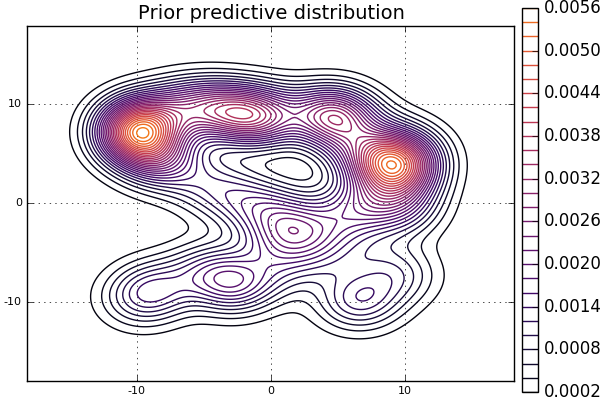

In [18]:
using Interact

@manipulate for x in wdict, a in 1:niter
  w=x[a]
  @time plot_priorpredictivedistr(w, clims=(0,0.008), levels=30);
end